<h1> 5. Assignments </h1>

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
from sklearn.metrics import roc_auc_score
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
#from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from csv file </h2>

In [2]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [3]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

In [4]:
x = df['question1']
preprocess(x)
x = df['question2']
preprocess(x)
#As data is huge, due to computation limitation we will randomly select data. we will try to pick data in a way so that it doesn't make data imbalance problem
df_s = df[df.is_duplicate == 1]
df_s = df_s.sample(n = 33000 ,replace=True) #0.055
df_ns = df[df.is_duplicate == 0]
df_ns = df_ns.sample(n = 25000,replace=True) #0.25
df_f = pd.concat([df_s,df_ns],axis=0)

In [5]:
X = df_f
y = df_f["is_duplicate"]
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(26036, 6)
(12824, 6)
(19140, 6)


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
X_train_q1 = list(X_train['question1'])

tfidf = TfidfVectorizer(lowercase=False, )
X_train_t1 = tfidf.fit_transform(X_train_q1)

X_cv_q1 = list(X_cv['question1'])

X_cv_t1 = tfidf.transform(X_cv_q1)
X_test_q1 = list(X_test['question1'])

X_test_t1 = tfidf.transform(X_test_q1)

In [7]:
X_train_q2 = list(X_train['question2'])
tfidf = TfidfVectorizer(lowercase=False, )
X_train_t2 = tfidf.fit_transform(X_train_q1)

X_cv_q2 = list(X_cv['question2'])

X_cv_t2 = tfidf.transform(X_cv_q2)
X_test_q2 = list(X_test['question2'])

X_test_t2 = tfidf.transform(X_test_q2) 
print(X_train_t1.shape)

(26036, 19901)


In [8]:
x_train_t = hstack((X_train_t1,X_train_t2)).tocsr()
x_cv_t = hstack((X_cv_t1,X_cv_t2)).tocsr()
x_test_t = hstack((X_test_t1,X_test_t2)).tocsr()

In [9]:
print("train data",x_train_t.shape,y_train.shape)
print("cv data",x_cv_t.shape,y_cv.shape)
print("test data",x_test_t.shape,y_test.shape)

train data (26036, 39802) (26036,)
cv data (12824, 39802) (12824,)
test data (19140, 39802) (19140,)


In [10]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.5799927611569164
For values of alpha =  0.0001 The log loss is: 0.572713778247328
For values of alpha =  0.001 The log loss is: 0.5950570971874924
For values of alpha =  0.01 The log loss is: 0.6211418781593416
For values of alpha =  0.1 The log loss is: 0.6411187529132575
For values of alpha =  1 The log loss is: 0.6469027257021929
For values of alpha =  10 The log loss is: 0.6475745266723779


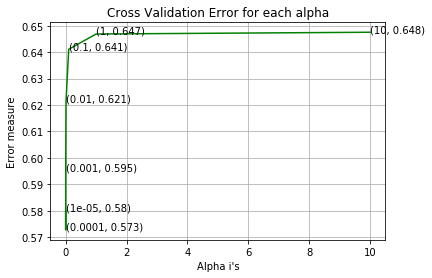

For values of best alpha =  0.0001 The train log loss is: 0.4896479958978907
For values of best alpha =  0.0001 The test log loss is: 0.57602004167894
Total number of data points : 19140


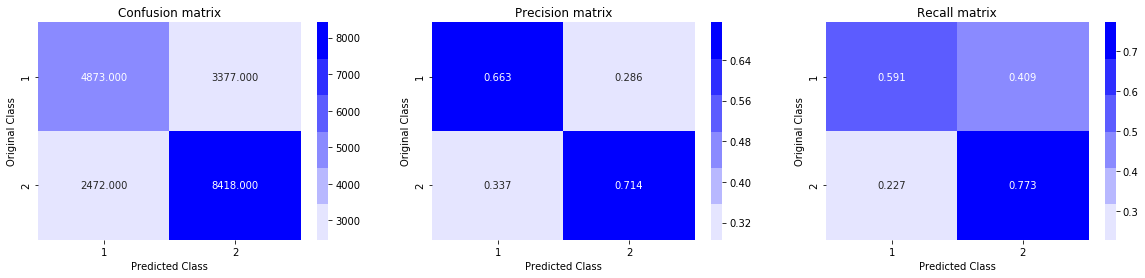

In [11]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train_t, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_t, y_train)
    predict_y = sig_clf.predict_proba(x_cv_t)
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train_t, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_t, y_train)

predict_y = sig_clf.predict_proba(x_train_t)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_t)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

#### test log loss is 0.54

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6054072678567504
For values of alpha =  0.0001 The log loss is: 0.592305691449934
For values of alpha =  0.001 The log loss is: 0.6576490269694816
For values of alpha =  0.01 The log loss is: 0.6836132620323886
For values of alpha =  0.1 The log loss is: 0.6836132620323886
For values of alpha =  1 The log loss is: 0.6836132620323886
For values of alpha =  10 The log loss is: 0.6836132620316425


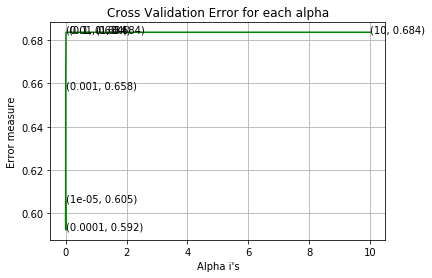

For values of best alpha =  0.0001 The train log loss is: 0.5564705603634277
For values of best alpha =  0.0001 The test log loss is: 0.5954774285055093
Total number of data points : 19140


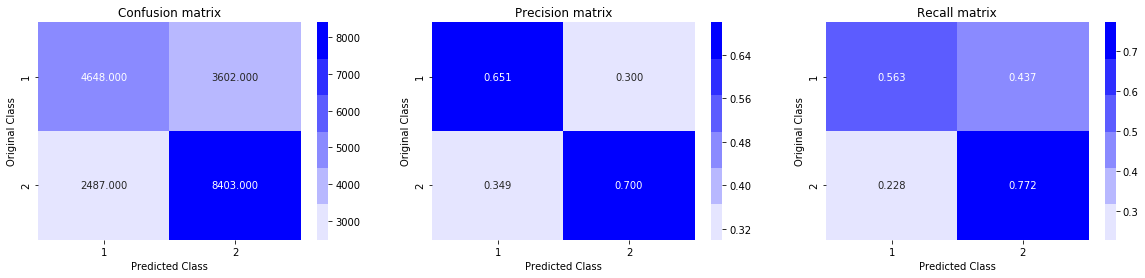

In [12]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(x_train_t, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_t, y_train)
    predict_y = sig_clf.predict_proba(x_cv_t)
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(x_train_t, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_t, y_train)

predict_y = sig_clf.predict_proba(x_train_t)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_t)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

#### test log loss is: .57

<h2> 4.6 XGBoost </h2>

In [13]:
import xgboost as xgb
from typing import List
from sklearn.metrics import log_loss
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['subsample'] = 1
predictions = 0
predict_y = 0
params['colsample_bytree'] = .7
params['scale_pos_weight'] = .7
params['min_child_weight'] = 3
rf_depth = [4, 5, 6, 9]
rf_estimators = [4000,6000,8000,9000]
q = []
log_los1 =  float()
min_loss = float()
test_score = []
test_score1 = []
for i in rf_depth:
    test_score1 = []
#    q = []
    for j in rf_estimators:
        params['max_depth'] = i
        params['n_estimators'] = j
        d_train = xgb.DMatrix(x_train_t, label=y_train)
        d_cv = xgb.DMatrix(x_cv_t, label=y_cv)
        watchlist = [(d_train, 'train'), (d_cv, 'valid')]
        bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)
        xgdmat = xgb.DMatrix(x_train_t,y_train)
        predict_y = bst.predict(d_cv)
        log_los1 = log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15)
        test_score1.append(log_los1)
    min_loss = min(test_score1)
    index = test_score1.index(min_loss)
    a = rf_estimators[index]
    q.append(a)
    test_score.append(min_loss)
print(test_score)
print(q)
#print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.67879	valid-logloss:0.680856
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.630253	valid-logloss:0.639673
[20]	train-logloss:0.611688	valid-logloss:0.627118
[30]	train-logloss:0.600273	valid-logloss:0.618729
[40]	train-logloss:0.590961	valid-logloss:0.613724
[50]	train-logloss:0.583832	valid-logloss:0.610457
[60]	train-logloss:0.577662	valid-logloss:0.606417
[70]	train-logloss:0.571969	valid-logloss:0.602433
[80]	train-logloss:0.567023	valid-logloss:0.600445
[90]	train-logloss:0.562798	valid-logloss:0.598673
[100]	train-logloss:0.558649	valid-logloss:0.5969
[110]	train-logloss:0.554508	valid-logloss:0.594838
[120]	train-logloss:0.550973	valid-logloss:0.593787
[130]	train-logloss:0.547498	valid-logloss:0.592618
[140]	train-logloss:0.544165	valid-logloss:0.591066
[150]	train-logloss:0.541201	valid-logloss:0.590355
[160]	train-logloss:0.538259	va

[250]	train-logloss:0.517571	valid-logloss:0.583275
[260]	train-logloss:0.515397	valid-logloss:0.582757
[270]	train-logloss:0.513165	valid-logloss:0.582757
[280]	train-logloss:0.510698	valid-logloss:0.581917
[290]	train-logloss:0.508146	valid-logloss:0.58129
[300]	train-logloss:0.506212	valid-logloss:0.58093
[310]	train-logloss:0.50432	valid-logloss:0.580166
[320]	train-logloss:0.502663	valid-logloss:0.580515
[330]	train-logloss:0.500482	valid-logloss:0.580157
[340]	train-logloss:0.498757	valid-logloss:0.579928
[350]	train-logloss:0.497154	valid-logloss:0.579497
[360]	train-logloss:0.495538	valid-logloss:0.579035
[370]	train-logloss:0.493995	valid-logloss:0.57874
[380]	train-logloss:0.492037	valid-logloss:0.5788
[390]	train-logloss:0.490083	valid-logloss:0.578716
[399]	train-logloss:0.48868	valid-logloss:0.578531
[0]	train-logloss:0.675824	valid-logloss:0.679201
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn

[110]	train-logloss:0.526189	valid-logloss:0.587073
[120]	train-logloss:0.522041	valid-logloss:0.585257
[130]	train-logloss:0.517761	valid-logloss:0.584079
[140]	train-logloss:0.512876	valid-logloss:0.583337
[150]	train-logloss:0.50961	valid-logloss:0.582103
[160]	train-logloss:0.505877	valid-logloss:0.58167
[170]	train-logloss:0.502149	valid-logloss:0.581045
[180]	train-logloss:0.49834	valid-logloss:0.580695
[190]	train-logloss:0.495311	valid-logloss:0.580178
[200]	train-logloss:0.492542	valid-logloss:0.579719
[210]	train-logloss:0.489511	valid-logloss:0.579485
[220]	train-logloss:0.486691	valid-logloss:0.579474
[230]	train-logloss:0.48375	valid-logloss:0.579908
Stopping. Best iteration:
[214]	train-logloss:0.488331	valid-logloss:0.579164

[0]	train-logloss:0.672834	valid-logloss:0.677348
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.614934	valid-logloss:0.6326

[20]	train-logloss:0.562999	valid-logloss:0.608795
[30]	train-logloss:0.548479	valid-logloss:0.601223
[40]	train-logloss:0.537175	valid-logloss:0.596711
[50]	train-logloss:0.527302	valid-logloss:0.593285
[60]	train-logloss:0.519553	valid-logloss:0.590715
[70]	train-logloss:0.511621	valid-logloss:0.588345
[80]	train-logloss:0.504652	valid-logloss:0.586202
[90]	train-logloss:0.498132	valid-logloss:0.585814
[100]	train-logloss:0.492658	valid-logloss:0.584671
[110]	train-logloss:0.487336	valid-logloss:0.583928
[120]	train-logloss:0.482359	valid-logloss:0.582837
[130]	train-logloss:0.476901	valid-logloss:0.582541
[140]	train-logloss:0.472513	valid-logloss:0.582259
[150]	train-logloss:0.467616	valid-logloss:0.581685
[160]	train-logloss:0.463309	valid-logloss:0.58158
[170]	train-logloss:0.459439	valid-logloss:0.581308
[180]	train-logloss:0.456015	valid-logloss:0.581366
[190]	train-logloss:0.452007	valid-logloss:0.580463
[200]	train-logloss:0.448141	valid-logloss:0.580575
[210]	train-logloss:0

In [14]:
#compute optimum estimator and depth
rf_depth = [4, 5, 7, 9, 11, 15,17]
rf_estimators = q
b = test_score
min_score = min(b)
row = b.index(min_score)
optimum_estimator = rf_estimators[row]
optimum_depth = rf_depth[row]
print("optimum_estimator ",optimum_estimator )
print("optimum_depth",optimum_depth)

optimum_estimator  4000
optimum_depth 5


[0]	valid-logloss:0.680292	train-logloss:0.675824
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 20 rounds.
[10]	valid-logloss:0.639717	train-logloss:0.622751
[20]	valid-logloss:0.627035	train-logloss:0.603358
[30]	valid-logloss:0.618358	train-logloss:0.588919
[40]	valid-logloss:0.612832	train-logloss:0.579501
[50]	valid-logloss:0.608558	train-logloss:0.572265
[60]	valid-logloss:0.604598	train-logloss:0.565186
[70]	valid-logloss:0.602403	train-logloss:0.55915
[80]	valid-logloss:0.600117	train-logloss:0.553179
[90]	valid-logloss:0.598385	train-logloss:0.548535
[100]	valid-logloss:0.5968	train-logloss:0.544203
[110]	valid-logloss:0.595052	train-logloss:0.540007
[120]	valid-logloss:0.593317	train-logloss:0.535477
[130]	valid-logloss:0.592038	train-logloss:0.53205
[140]	valid-logloss:0.591293	train-logloss:0.528582
[150]	valid-logloss:0.590544	train-logloss:0.524634
[160]	valid-logloss:0.589438	tra

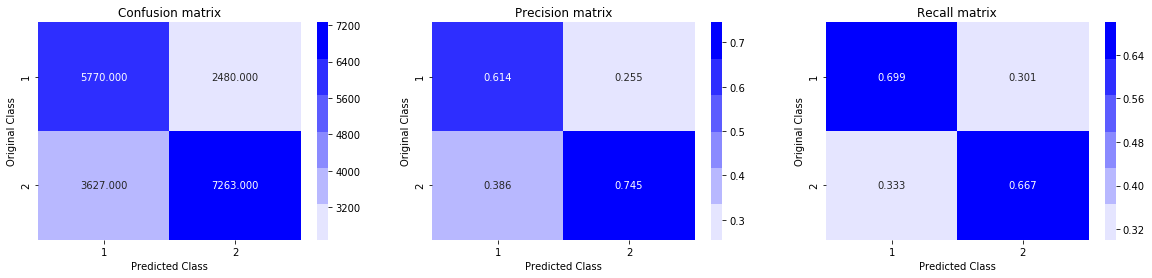

In [15]:
# import xgboost as xgb
from sklearn.metrics import log_loss
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
#params['eta'] = 0.02
params['max_depth'] = optimum_depth
#params['learning_rate'] = .06
#params['gamma'] = .4
params['n_estimators'] = optimum_estimator
params['subsample'] = 1
predictions = 0
predict_y = 0
params['colsample_bytree'] = .7
params['scale_pos_weight'] = .7
params['min_child_weight'] = 3
d_test = xgb.DMatrix(x_test_t, label=y_test)
d_train = xgb.DMatrix(x_train_t, label=y_train)
watchlist = [(d_test, 'valid'),(d_train, 'train')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(x_train_t,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y,labels=clf.classes_, eps=1e-15))
predictions = [int(round(value)) for value in predict_y]
plot_confusion_matrix(y_test, predictions)

#### test log loss is: .55

In [88]:
from sklearn.model_selection import RandomizedSearchCV
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params = {
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.6, 0.7, 0.8, 0.9, 1.0],   
        'max_depth': [2,3,4,5,6,7,8,9,10],
        'min_child_weight': [5.0, 10.0, 50.0, 100.0],
        'gamma': [ 0.7, 0.8, 0.9, 1.0],
        'n_estimators': [5,10,50,100,200,500]}

from sklearn.ensemble import RandomForestRegressor
clf = xgb.XGBClassifier()

rf_random = RandomizedSearchCV(clf, param_distributions = params, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train_t, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0...
                                        'colsample_bytree': [0.4, 0.5, 0.6, 0.7,
                                                             0.8, 0.9, 1.0],
                                        'gamma': [0.7, 0.8, 0.9,

In [89]:
max_depth_opt, learning_rate_opt = rf_random.best_params_.get('max_depth'), rf_random.best_params_.get('learning_rate')
min_child_weight_opt = rf_random.best_params_.get('min_child_weight')
gamma_opt = rf_random.best_params_.get('gamma')
colsample_bylevel_opt = rf_random.best_params_.get('colsample_bylevel')
colsample_bytree_opt, subsample_opt = rf_random.best_params_.get('colsample_bytree'), rf_random.best_params_.get('subsample')
n_estimators_opt = rf_random.best_params_.get('n_estimators')

In [90]:
params = {   
        'max_depth': max_depth_opt,
        'min_child_weight': min_child_weight_opt,
        'gamma': gamma_opt,
        'n_estimators': n_estimators_opt,
        'subsample': subsample_opt,
        'colsample_bytree': colsample_bytree_opt,
        'colsample_bylevel': colsample_bylevel_opt,
        'learning_rate': learning_rate_opt}

In [91]:
print(params)

{'max_depth': 9, 'min_child_weight': 5.0, 'gamma': 0.8, 'n_estimators': 200, 'subsample': 1.0, 'colsample_bytree': 0.8, 'colsample_bylevel': 1.0, 'learning_rate': 0.1}


[0]	valid-rmse:0.495467	train-rmse:0.493898
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 20 rounds.
[10]	valid-rmse:0.473454	train-rmse:0.4602
[20]	valid-rmse:0.466428	train-rmse:0.446987
[30]	valid-rmse:0.462915	train-rmse:0.439877
[40]	valid-rmse:0.460801	train-rmse:0.435106
[50]	valid-rmse:0.458837	train-rmse:0.431178
[60]	valid-rmse:0.457342	train-rmse:0.428048
[70]	valid-rmse:0.456225	train-rmse:0.425369
[80]	valid-rmse:0.454983	train-rmse:0.422403
[90]	valid-rmse:0.454171	train-rmse:0.420196
[100]	valid-rmse:0.453479	train-rmse:0.418127
[110]	valid-rmse:0.452816	train-rmse:0.416165
[120]	valid-rmse:0.452216	train-rmse:0.414332
[130]	valid-rmse:0.45173	train-rmse:0.412765
[140]	valid-rmse:0.45116	train-rmse:0.411045
[150]	valid-rmse:0.450698	train-rmse:0.409497
[160]	valid-rmse:0.450378	train-rmse:0.408026
[170]	valid-rmse:0.449984	train-rmse:0.406649
[180]	valid-rmse:0.449652	train-rmse:0.405

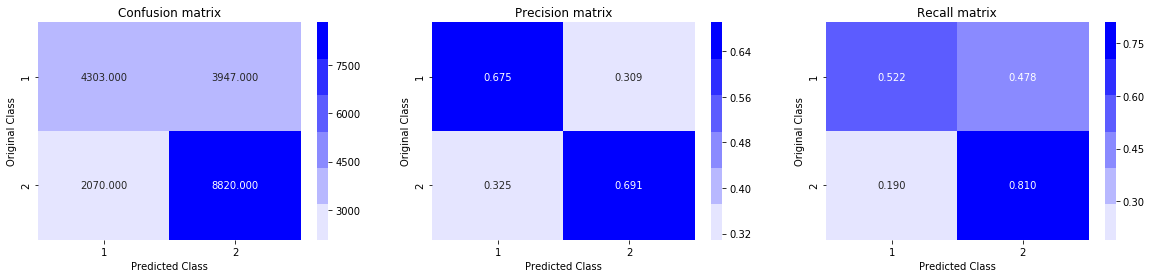

The test log loss is: 0.5840648877620346


In [92]:
d_test = xgb.DMatrix(x_test_t, label=y_test)
d_train = xgb.DMatrix(x_train_t, label=y_train)
watchlist = [(d_test, 'valid'),(d_train, 'train')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)
predictions = []
xgdmat = xgb.DMatrix(x_train_t,y_train)
predict_y =bst.predict(d_test, xgdmat)
#print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-7))
predictions = [int(round(value)) for value in predict_y]
plot_confusion_matrix(y_test, predictions)
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-7))

From test data we have received log loss = 0.58